In [0]:
# # <span style = 'color:darkred'> Imports & notebook settings </span style>

# - ### <a href=#imports> Imports & settings </a>
# - ### <a href=#read_in> Reading in all tweets </a>
# - ### <a href=#time_distr> Distribution over time </a>
# - ### <a href=#filter> Filter for relevant tweets </a>

# # <span style = 'color:darkred'> Imports & settings</span style> <a name='imports' />


In [0]:
################################ JUPYTER ###################################
from IPython.core.display import display, HTML
from IPython.display import Image
display(HTML("<style>.container { width:100% !important; }</style>"))

################################ SPARK ###################################

#import findspark
#findspark.init(spark_home = "/home/sachadubrulle/spark-2.1.0")
#findspark.init(spark_home = "/Users/sachadubrulle/spark-2.1.0")
import pyspark

from pyspark.sql import SQLContext, SparkSession

try:
    sc = pyspark.SparkContext(appName = 'App')
    spark = SparkSession(sparkContext=sc)
    print("SparkSession initialized")
except ValueError:
    print("SparkSession already initialized")
    
from pyspark.sql.functions import udf, explode, lower, regexp_extract, split, col, regexp_replace
from pyspark.sql.types import StringType, TimestampType, IntegerType, ArrayType, DoubleType, BooleanType
from pyspark.ml.feature import Binarizer, StringIndexer, StringIndexerModel, OneHotEncoder, MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

################################ PYTHON ###################################
    
from datetime import datetime
import re
import pandas as pd
pd.set_option("display.max_colwidth", -1)

import numpy as np
import urllib.request, urllib.error, urllib.parse
get_ipython().run_line_magic('matplotlib', 'inline')
from matplotlib import pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, WeekdayLocator, DateFormatter
from dateutil.relativedelta import relativedelta

colors = {"orange": np.array([255,128,14], dtype = np.float16),
          "blue": np.array([0,107,164], dtype = np.float16),
          "green": np.array([44, 160, 44], dtype = np.float16)
         }

for k in list(colors.keys()):
    colors[k] = np.divide(colors[k], 255)

    ################################ Alpha Vantage API ###################################
import requests
import alpha_vantage
import csv
#This is our current api key, you might have to request a new one
AV_API_key="OES7ORJTQ21CYZM9"
AV_API_URL = "https://www.alphavantage.co/query"

SparkSession already initialized


In [0]:
# This notebook is based on data that was mined from twitter. Primarily, twitter was mined using a list of keywords, all related to Initial Public Offerings, herinafter IPO's. The list of keywords contained the names and abbreviations or tickers for a number of companies that were know to perform their IPO soon, but also using some more generic words related to IPO's. The data ranges from the end of March 2016 until the end of march 2017 and hence comprises an entire year.

# <span style = 'color:darkred'> Functions and udfs </span style>

### <span style = 'color:darkgreen'> Python functions </span style>


In [0]:
ipo_expression = ' #ipo | ipo '
cashtag_expression = "(\$[a-z]{1,6})+"

companies_list = []
with open("company_names.txt", "r") as f: # Importing file that contains company names that we have to concentrate or analyze
    companies_list = f.readlines()
    companies_list = [x.replace("\n", "").lower() for x in companies_list]
#extracting cash tags
def cashtag_re_extract(text_column):
    cashtag_list = re.findall(cashtag_expression, text_column)
    ticker_list = [x[1:].upper() for x in cashtag_list]
    return ticker_list

# returns 0 if column is empty (no regexp match found), 1 otherwise (at least one regexp match found)
def contains_company_name(text_column):
    company_mentions = 0
    for i in companies_list:
        # strip spaces out of tweets
        if i in text_column.replace(" ", ""):
            company_mentions += 1
    return company_mentions

def non_empty_column(ipo_cashtag_column):
    if len(ipo_cashtag_column) > 0:
        return 1
    else:
        return 0

# check tweets that contain RT
def contains_pattern(column):
    if column == "":
        return 0
    else:
        return 1

def user_seniority(user_created_at):
    today = datetime.today()
    user_created_at_ts = datetime.strptime(user_created_at, "%a %b %d %H:%M:%S +0000 %Y")
    delta = relativedelta(today, user_created_at_ts)
    return delta.years  + delta.months/12.0

def contains_hashtags(hashtags):
    if len(hashtags) == 0:
        return 0
    else:
        return 1


In [0]:
### <span style = 'color:darkgreen'> Spark UDF </span style>

In [0]:
# user defined functions by using above functions to extraction data from the JSON files
udf_cashtag_re_extract = udf(cashtag_re_extract, ArrayType(elementType = StringType()))
udf_contains_company_name = udf(contains_company_name, IntegerType())
non_empty_column_udf = udf(non_empty_column)
udf_contains_pattern = udf(contains_pattern)

# Define UDF to transform timestamp from StringType to TimestampType
udf_datatime = udf(lambda string: datetime.strptime(string, "%a %b %d %H:%M:%S +0000 %Y"), TimestampType())

udf_day_of_week = udf(lambda x: str(x.strftime('%A')), StringType())


In [0]:
# <span style = 'color:darkred'> Read in and basic transformations </span style>



In [0]:
## original #df = (spark.read.json("/home/sachadubrulle/Data/tweets_IPO/done_batches/M*B3/*.json")
#### server location #(spark.read.json("/mnt/bdata1/twitter/archief/ipo/tweets/*.json")) Or the bdata4 location
df = (spark.read.json("/home/mma/Downloads/IPO_project/tweets/*.json")
        # Add lower text column and timestamp
        .select("*", 
               udf_datatime(col("created_at")).alias("timestamp"),
               lower(col("text")).alias("text_lower")
               )
        # Drop created_at string column
        .drop("created_at")
        # Add columns related to ipo, cashtags & retweet patterns
        .select("*", 
               udf_cashtag_re_extract('text_lower').alias("cashtags"),
               non_empty_column_udf(regexp_extract('text_lower', ipo_expression, 0)).alias("contains_ipo"),
               non_empty_column_udf(regexp_extract('text_lower', cashtag_expression, 0)).alias("contains_cashtag"),
               udf_contains_company_name("text_lower").alias("contains_company_name"),
               regexp_extract(str = "text", pattern = "^RT @[A-Za-z0-9]+: ", idx = 0).alias("retweet_pattern")
               )
        .select("*", 
               udf_contains_pattern("retweet_pattern").alias("contains_RT_pattern")
              )
     )

#df.cache()

nbr_total = df.count()
print("The filtered dataset contains {} tweets".format(nbr_total))
print("\nThe columns in this dataset are the following:\n{}".format(str(df.columns)))


The filtered dataset contains 66000 tweets

The columns in this dataset are the following:
['contributors', 'coordinates', 'display_text_range', 'entities', 'extended_entities', 'extended_tweet', 'favorite_count', 'favorited', 'filter_level', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'place', 'possibly_sensitive', 'quote_count', 'quoted_status', 'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink', 'reply_count', 'retweet_count', 'retweeted', 'retweeted_status', 'source', 'text', 'timestamp_ms', 'truncated', 'user', 'withheld_in_countries', 'timestamp', 'text_lower', 'cashtags', 'contains_ipo', 'contains_cashtag', 'contains_company_name', 'retweet_pattern', 'contains_RT_pattern']


In [0]:
### <span style = 'color:darkgreen'> Filter out all available tickers and mine their stock prices  </span style>


In [0]:

#df.select("cashtags").show(5)

+--------+
|cashtags|
+--------+
|      []|
|      []|
|      []|
|      []|
|      []|
+--------+
only showing top 5 rows



In [0]:

#df.select(explode("cashtags")).show(5)

+------+
|   col|
+------+
|BTCUSD|
|   BTC|
|   TAO|
|  FSHP|
|   IPO|
+------+
only showing top 5 rows



In [2]:
# calculating the amount of cashtags present in the available tweets
cashtag_count = (df.select(explode("cashtags").alias("cashtag"))
                   .groupBy("cashtag").count()
                   .sort("count", ascending = False)
                 )

print(("Considering all tweets, there is a total amount of {} cashtags.\n" +  
       "In total, there are {} distinct cashtags.\n").format(cashtag_count.count(), 
                                                                cashtag_count.distinct().count()))

cashtag_count.show(5)

## Select only tickers that occur often enough
TRESHOLD = 30 # threshold as per requirement or to get more accurate sentiment score
ticker_rdd = cashtag_count.filter("count >= {}".format(TRESHOLD)).select("cashtag").collect()

ticker_list = []
for i in ticker_rdd:
    ticker_list.append(i.cashtag)
print("Let's look at the most occuring tickers: " + str(ticker_list[0:10]))


NameError: name 'df' is not defined

In [0]:
'''#### Mine stock prices
problem_stocks = []
for ticker in ticker_list:
    try:
        text = urllib.request.urlopen("http://chart.finance.yahoo.com/table.csv?s={}&a=2&b=1&c=2016&d=3&e=12&f=2017&g=d&ignore=.csv".format(ticker)).read()
        with open("stock_mining/{}.csv".format(ticker), "w") as f:
            f.write(text)
        print("{} was written out succesfully".format(ticker))
    
    except:
        print("Problem fetching {}".format(ticker))
        problem_stocks.append(ticker)
    
# Print out cashtags that have no corresponding stock data
print(problem_stocks)'''

'#### Mine stock prices\nproblem_stocks = []\nfor ticker in ticker_list:\n    try:\n        text = urllib.request.urlopen("http://chart.finance.yahoo.com/table.csv?s={}&a=2&b=1&c=2016&d=3&e=12&f=2017&g=d&ignore=.csv".format(ticker)).read()\n        with open("stock_mining/{}.csv".format(ticker), "w") as f:\n            f.write(text)\n        print("{} was written out succesfully".format(ticker))\n    \n    except:\n        print("Problem fetching {}".format(ticker))\n        problem_stocks.append(ticker)\n    \n# Print out cashtags that have no corresponding stock data\nprint(problem_stocks)'

In [0]:
# Mine stock prices adjusted
import time
problem_stocks = []
i = 1
#We'll iterate over all cashtags above the treshold, referd to as tickers.
for ticker in ticker_list:
    #We can only use the api 5 times per minute, that's why we sleep for a minute (+ some cushioning)
    #every 5 times
    if (i%5 == 0):
        time.sleep(65)
    try:
        #increase our counter, so all the csv files get the correct input
        i = i+1
        #fetching the stock prices, all info can be found here: https://www.alphavantage.co/documentation/
        text = urllib.request.urlopen("https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={}&outputsize=full&interval=60min&apikey={}&datatype=csv".format(ticker,AV_API_key)).read()
    except Exception as error:
        #If there is an error, the tickers get added to a list.
        print(error)
        print("Problem fetching {}".format(ticker))
        problem_stocks.append(ticker)
    print(ticker)
    #We split the text into an array, first we need to extract every line, these end in \\r\\n
    #then we split them on every comma, this is so we can convert them to a csv file later.
    textrows = str(text).split("\\r\\n")
    textcsv = map(lambda x:(x.split(',')), textrows)
    with open("/home/mma/Downloads/IPO_project/stock_mining/{}.csv".format(ticker), "w") as f:
        writer = csv.writer(f)
        writer.writerows(textcsv)
# Print out cashtags that have no corresponding stock data
print(problem_stocks)

PVTL
IPO
NIO
SURF
TLRY
EAF
SPY
MOR
ZNZBF
FB
ZUO
FCI
WAVES
SPOT


KeyboardInterrupt: 

In [0]:
# Plot tickers
df.show()

+------------+-----------+------------------+--------------------+-----------------+--------------+--------------+---------+------------+----+------------------+------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+-----+------------------+-----------+--------------------+------------------+--------------------+-----------------------+-----------+-------------+---------+--------------------+--------------------+--------------------+-------------+---------+--------------------+---------------------+-------------------+--------------------+--------+------------+----------------+---------------------+--------------------+-------------------+
|contributors|coordinates|display_text_range|            entities|extended_entities|extended_tweet|favorite_count|favorited|filter_level| geo|                id|            id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str

In [0]:
# function to plot the tickers information(number of tweets vs the price fluctuation)
def plot_ticker(df, stock_name, image_save_dir = "stock_plots", save_image = False):
    stock_name = stock_name.upper()
################ NEW #####################
    
#    CT_TS_pd = (df.select(("timestamp"))#, explode("cashtags").alias("cashtag"))
#                                #.filter("cashtag == '{}'".format(stock_name))
#                              ).toPandas()
   # CT_TS_pd = (df.select(Timestamp.("timestamp").tz_localize)
################ OLD#######################
     # cashtag count per day
    CT_TS_pd = (df.select("timestamp", explode("cashtags").alias("cashtag"))
                                .filter("cashtag == '{}'".format(stock_name))
                              ).toPandas()   
#############################################

    CT_TS_pd["date"] = CT_TS_pd["timestamp"].apply(lambda x: x.date())

    CT_TS_pd["date_str"] = CT_TS_pd["date"].apply(lambda x: str(x))
    CT_TS_pd.drop("timestamp", axis = 1, inplace = True)

    #cashtag count per day
    CT_TWTCOUNT_DATE = (pd.DataFrame(data = CT_TS_pd["date_str"].value_counts())
                          .sort_index(ascending = True)
                          .reset_index(drop = False)
                          .rename(index=str, columns={"index": "date", "date_str": "tweet_count"})
                        )

    # Read stock prices from stock prices
    stock_prices = (pd.read_csv("stock_mining/{}.csv".format(stock_name))
            .drop(["open", "high", "low", "volume"], axis = 1)
            .rename(index=str, columns={"b'timestamp": "date", "close": "closing_price"})
            .sort_values("date", ascending = True)
          )  

    full_stock_df = (pd.merge(left = stock_prices, 
                                 right = CT_TWTCOUNT_DATE, 
                                 on = "date", 
                                 how = "right")
                            .sort_values("date", ascending = True)
                            .dropna(axis = 0, how = "any", subset = ["closing_price"])
                            .fillna(value = 0)
                         )
    
    # PLOTTING
    fig = plt.figure(figsize = (20,7))

    ax1 = fig.add_subplot(111)
    ax1.set_title(stock_name.upper())
    ax1.plot(full_stock_df["tweet_count"], color= colors["orange"], linewidth = 2.5)
    ax1.set_ylabel('tweet count')
    ax1.legend(loc = 1)
    
    ax2 = ax1.twinx()
    ax2.plot(full_stock_df["closing_price"].ix[(full_stock_df.closing_price != 0)], color = colors["blue"], linewidth = 2.5)
    ax2.set_ylabel('Closing_price')
    
    ax2.xaxis.set_major_locator(YearLocator())
    ax2.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax2.xaxis.set_minor_locator(MonthLocator())
    # format the coords message box
    ax2.format_xdata = DateFormatter('%Y-%m-%d')
    ax2.grid(True)
    ax2.legend(loc = 1)
    
    print("Count is orange, stock price is blue")
    if save_image is True:
        fig.savefig('{}/{}.png'.format(image_save_dir, stock_name))
        print("Image is saved as in the following location: {}/{}.png".format(image_save_dir, stock_name))
    fig.show()
    #return full_stock_df

/home/mma//lib/python3.7/site-packages/ipykernel_launcher.py:54: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/mma//lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Count is orange, stock price is blue


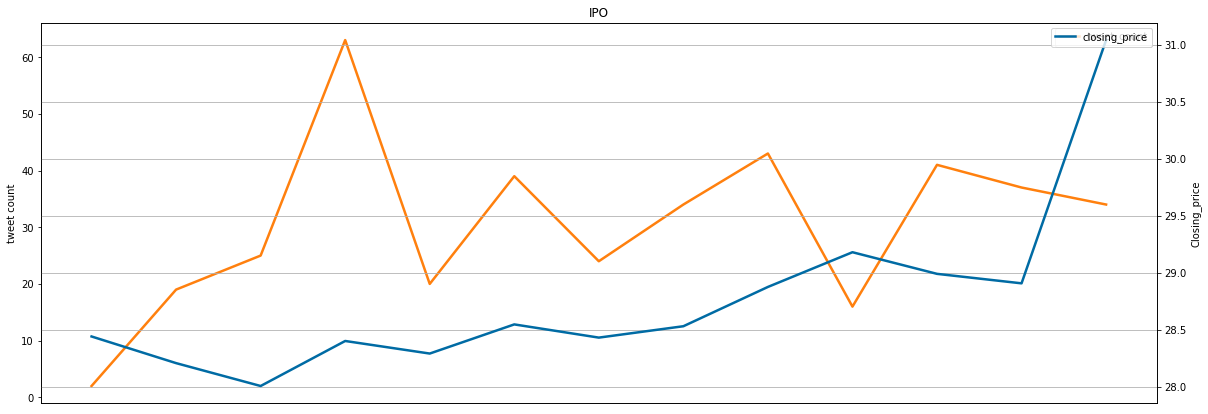

In [0]:
# Most plot_tickers have problems with the : Cannot convert tz-naive Timestamp, use tz_localize to localize = > problem with the timestamp convertion to panda's.
# look at the code of Twitter filter or twitter analyse for a solution, timestamps have also been used. 
# yet the plots do not give this error. the conversion has been done differently
plot_ticker(df, "IPO", save_image=False)

In [10]:
# # <span style = 'color : darkred'>  One observation per tweet </span style>

# ### <span style = 'color:darkgreen'> Keep one observation per tweet </span style>
# 
# The mechanism of tweets and retweets is the following:
# 
# - An original tweet is sent out
# - Somebody retweets:
#     - The retweet is preceded by **RT @username_original_tweet: [text of original tweet]**
#     - The retweet count is incremented in the original tweet BUT in the retweet as well
#  
# That means, even if we don't have the original tweet, we can obtain in by removing the pattern **RT @username_original_tweet:** from the retweet. This is important because, as shown below, we won't always have access to the original tweet.
# 
# Another important step to take, is to delete all duplicates. Ultimately, we're going to be training and testing models on these tweets. Predicting a number of retweets using multiple training examples (i.e. retweets) per tweet would be erroneous. Hence we're going to take a few steps to try and avoid having  duplicate tweets in our dataset.
# 
# 


In [11]:
### <span style = 'color:darkgreen'> Rename & unnest important columns </span style>

In [12]:
#Tweets can contain a lot of useless data or data that's hard to analyze. This includes the retweet patern,
#The hashtags, truncations and more.
def clean_text(text):
    # Remove pattern that signifies retweet
    clean_text = re.sub(pattern = "RT\s@[a-zA-Z0-9]+:\s", repl = "", string = text)
    clean_text = re.sub(r"\'s", " ", clean_text)
    clean_text = re.sub(r"\'ve", " have ", clean_text)
    clean_text = re.sub(r"can't", "cannot ", clean_text)
    clean_text = re.sub(r"n't", " not ", clean_text)
    clean_text = re.sub(r"i'm", "i am ", clean_text)
    clean_text = re.sub(r"\'re", " are ", clean_text)
    clean_text = re.sub(r"\'d", " would ", clean_text)
    clean_text = re.sub(r"\'ll", " will ", clean_text)
    clean_text = re.sub(pattern = "\$[A-Za-z]{1,5}", repl = " ticker ", string = clean_text)
    clean_text = re.sub(pattern =  "w/", repl = "with", string = clean_text)
    clean_text = re.sub(pattern = "http(s)?:\/\/[^\s]+", repl = "website", string = clean_text)
    clean_text = re.sub(pattern = "[\|!,\|?\.\[\]\"'(\n):\$\&\#\-\%\+]+", repl = " ", string = clean_text)
    clean_text = re.sub(pattern = ' +', repl = ' ', string = clean_text)
    clean_text = re.sub(pattern = "@[A-Za-z0-9]+", repl = "user", string= clean_text)
    clean_text = clean_text.lower()
    return clean_text
    
udf_clean_text = udf(clean_text, StringType())

NameError: name 'udf' is not defined

In [13]:
clean_text("RT @VIZIO: @blabla Ever wonder what it's like  new vizio 56465% +22 d24d1 24 class led smart tv 1080p new 2016 model 13899end date wednesday jun... website to " +            "work w/ at\n\n VIZIO? Check out our company profile: https://t.co/IkJXNZ9pL4 https://t.co/TWSixQQnU")



NameError: name 're' is not defined

In [14]:
#function to find url in the tweet
def contains_url(isNotNull):
    if isNotNull == True:
        return 1
    else:
        return 0

In [15]:

df.createOrReplaceTempView("DF_SQL") # creating a temporaary view table

#performing descriptive stats on tweets 
df_distinct_tweets = (
    spark.sql("SELECT entities, extended_entities, favorite_count, id_str, in_reply_to_status_id_str, \
                      is_quote_status, lang, place, a.text, user, a.timestamp, a.retweet_count, \
                      a.cashtags, a.contains_ipo, a.contains_cashtag \
               FROM DF_SQL a Inner JOIN \
                           (SELECT text, retweet_count, min(timestamp) as timestamp \
                           FROM DF_SQL \
                           GROUP BY text, retweet_count \
                           ) b \
                ON  a.text = b.text \
                AND a.retweet_count=b.retweet_count \
                AND a.timestamp = b.timestamp")
             ).distinct()

NameError: name 'df' is not defined

In [16]:
#df_distinct_tweets.printSchema()

In [17]:
# extracting distinct tweets from the cleaned tweets. There is chance of happening retweeting
df_distinct_tweets = (df_distinct_tweets
        .withColumn("cashtag_count", udf(lambda x: len(x), IntegerType())(col("cashtags")))
    # ENTITIES  
        .withColumn("hashtags", col("entities.hashtags"))
        .withColumn("hashtag_count", udf(lambda x: len(x), IntegerType())(col("hashtags")))
        .withColumn("contains_hashtags", udf(contains_hashtags, IntegerType())(col("hashtags")))
        .withColumn("contains_url", udf(contains_url, IntegerType())(col("entities.media.display_url").isNotNull()))
        .withColumn("user_mentions_count", udf(lambda x: len(x), IntegerType())(col("entities.user_mentions")))
        .drop("entities")
    # USER
        .withColumn("user_seniority", udf(user_seniority, DoubleType())("user.created_at"))
        .withColumn("user_description", col("user.description"))
        .withColumn("user_favourites_count", col("user.favourites_count"))
        .withColumn("user_friends_count", col("user.friends_count"))
        .withColumn("user_followers_count", col("user.followers_count"))
        #.withColumn("user_description_clean", udf_clean_text(col("user_description")))
        .drop("user")
    # PLACE
        .drop("place")
    # EXTENDED_ENTITIES
        .drop("extended_entities")
        .withColumn("retweet_count_double", col("retweet_count").cast("double"))
        .withColumn("day_of_week", udf_day_of_week(col("timestamp")))
        .withColumn("text_clean", udf_clean_text(col("text")))
        .withColumn("clean_text_len", udf(lambda x: len(x), IntegerType())("text_clean"))
        .withColumn("nbr_words",  udf(lambda x: len(x.split(" ")), IntegerType())(col("text_clean")))
                     )

df_distinct_tweets.printSchema()

# df_distinct_tweets.write.parquet("/home/sachadubrulle/Data/tweets_IPO/ML_features.parquet", mode = "overwrite")



NameError: name 'df_distinct_tweets' is not defined

In [18]:
#df_distinct_tweets = spark.read.parquet("/home/sachadubrulle/Data/tweets_IPO/ML_features.parquet/")


In [19]:
# <span style = 'color:darkred'> Machine learning in Spark, the use of pipelines </span style>


In [7]:
all_columns = df_distinct_tweets.columns
#print all_columns
# segrigating all text and non-text columns
non_text_num_cols = ["user_seniority", "user_favourites_count", "user_friends_count", "user_followers_count"]
non_text_cat_cols = ["day_of_week"]
text_num_cols = ["cashtag_count", "hashtag_count"]
text_cat_cols = ["lang", "contains_cashtag", "contains_ipo", "contains_hashtags", "contains_url"]
dependent_variable = ["retweet_count"]
text = ["clean_text"]



NameError: name 'df_distinct_tweets' is not defined

In [0]:
### <span style = 'color:darkgreen'> Preparing distinct feature vectors </span style>


In [4]:
# function for encoding the text
def prepare_feature_vectors(df, num_columns, cat_columns):
    stringIndexers = []
    indexed_cols = []

    encoders = []
    encoded_cols = []

    for column in cat_columns:
        inCol= column
        outCol = column + "indexed"
        stringIndexer = StringIndexer(inputCol = inCol, outputCol=outCol)

        stringIndexers.append(stringIndexer)
        indexed_cols.append(outCol)

    for column in indexed_cols:
        inCol= column
        outCol = column + "encoded"
        encoder = OneHotEncoder(inputCol=inCol, outputCol=outCol)

        encoders.append(encoder)
        encoded_cols.append(outCol)
        
    binarizer = Binarizer(inputCol = "retweet_count_double", outputCol = "retweets_binary", threshold=0.9)

    assembler = VectorAssembler(inputCols= num_columns + encoded_cols, outputCol="input_features")

    pipeline = Pipeline(stages= stringIndexers + encoders + [binarizer, assembler])
    pipelineModel = pipeline.fit(df)
    
    
    transformed_df = (pipelineModel.transform(df)
                                   .select("input_features", 
                                            col("retweets_binary").cast("integer"), 
                                            "retweet_count"
                                          )
                     )
    
    return transformed_df
    

In [6]:

# applying the 'prepare_feature_vectors' function to encode the text
text_features_df = prepare_feature_vectors(df = df_distinct_tweets,                           
                                           num_columns = text_num_cols,
                                           cat_columns = text_cat_cols)

text_features_df.show(20, truncate=False)

NameError: name 'df_distinct_tweets' is not defined

In [0]:

# applying the 'prepare_feature_vectors' function to encode the text
non_text_features_df = prepare_feature_vectors(df = df_distinct_tweets,
                                               num_columns = non_text_num_cols, 
                                               cat_columns = non_text_cat_cols)

non_text_features_df.show(5, truncate=False)


+---------------------------------------------------------------+---------------+-------------+
|input_features                                                 |retweets_binary|retweet_count|
+---------------------------------------------------------------+---------------+-------------+
|(10,[0,1,2,3,7],[3.6666666666666665,44.0,1156.0,332.0,1.0])    |0              |0            |
|(10,[0,1,2,3,7],[2.5,1768.0,655.0,174.0,1.0])                  |0              |0            |
|(10,[0,1,2,3,7],[3.1666666666666665,10904.0,2190.0,1562.0,1.0])|0              |0            |
|(10,[0,2,3,7],[2.3333333333333335,850.0,696.0,1.0])            |0              |0            |
|(10,[0,1,2,3,7],[1.4166666666666667,1024.0,1185.0,681.0,1.0])  |0              |0            |
+---------------------------------------------------------------+---------------+-------------+
only showing top 5 rows



In [0]:

# applying the 'prepare_feature_vectors' function to encode the text
all_features_df = prepare_feature_vectors(df = df_distinct_tweets,
                                          num_columns = text_num_cols + non_text_num_cols, 
                                          cat_columns = text_cat_cols + non_text_cat_cols)

all_features_df.show(5, truncate=False)


+--------------------------------------------------------------------------------------------------+---------------+-------------+
|input_features                                                                                    |retweets_binary|retweet_count|
+--------------------------------------------------------------------------------------------------+---------------+-------------+
|(63,[2,3,4,5,6,53,54,55,56,60],[3.6666666666666665,44.0,1156.0,332.0,1.0,1.0,1.0,1.0,1.0,1.0])    |0              |0            |
|(63,[2,3,4,5,6,53,54,55,56,60],[2.5,1768.0,655.0,174.0,1.0,1.0,1.0,1.0,1.0,1.0])                  |0              |0            |
|(63,[2,3,4,5,6,53,54,55,56,60],[3.1666666666666665,10904.0,2190.0,1562.0,1.0,1.0,1.0,1.0,1.0,1.0])|0              |0            |
|(63,[2,4,5,10,53,54,55,56,60],[2.3333333333333335,850.0,696.0,1.0,1.0,1.0,1.0,1.0,1.0])           |0              |0            |
|(63,[1,2,3,4,5,6,53,54,56,60],[3.0,1.4166666666666667,1024.0,1185.0,681.0,1.0,1.0,

In [0]:
### <span style = 'color:darkgreen'> Models </span style>

In [0]:
# Creating results data frame to store all the score from the algorithms
results  = pd.DataFrame(columns = ["algorithm", "train AUC", "test AUC"])
results

,algorithm,train AUC,test AUC


In [0]:
# function for Logistic Regression
def LR_classification(model_description, df, output_column = "retweets_binary"):
    
    train, test = df.randomSplit([0.8, 0.2], seed = 42)
    
    lr = LogisticRegression(featuresCol = "input_features", labelCol="retweets_binary")
    lr_model = lr.fit(train)

    train_predictions = lr_model.transform(train)
    test_predictions = lr_model.transform(test)
    
    AUC_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", 
                                                  labelCol="retweets_binary", 
                                                  metricName="areaUnderROC")

    AUC_train = AUC_evaluator.evaluate(train_predictions)
    AUC_test = AUC_evaluator.evaluate(test_predictions)
    print("###################" + model_description.upper() + "##################")
    print("TRAIN AUC:       {}".format(AUC_train))
    print("TEST AUC:        {}".format(AUC_test))
    
    global results
    results = results.append({"algorithm": model_description, "train AUC": AUC_train, "test AUC": AUC_test}, 
                             ignore_index=True)
    
    #return lr_model


In [0]:
#Function for Random Forest
def RF_classification(model_description, num_trees, df, output_column = "retweets_binary"):
    
    train, test = df.randomSplit([0.8, 0.2], seed = 42)
    
    rf = RandomForestClassifier(numTrees=num_trees, featuresCol = "input_features", labelCol="retweets_binary")
    rf_model = rf.fit(train)

    train_predictions = rf_model.transform(train)
    test_predictions = rf_model.transform(test)
    
    AUC_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", 
                                                  labelCol="retweets_binary", 
                                                  metricName="areaUnderROC")

    AUC_train = AUC_evaluator.evaluate(train_predictions)
    AUC_test = AUC_evaluator.evaluate(test_predictions)
    print("###################" + model_description.upper() + "##################")
    print("TRAIN AUC:       {}".format(AUC_train))
    print("TEST AUC:        {}".format(AUC_test))
    
    global results
    results = results.append({"algorithm": model_description, "train AUC": AUC_train, "test AUC": AUC_test}, 
                             ignore_index=True)
    
    #return rf_model

In [0]:
 #### <span style = 'color:darkorange'> Logistic regression </span style>

In [0]:
# Running Logistic Regression model on non text features
LR_classification(model_description = "Logistic regression, non text features",
                  df = non_text_features_df, 
                  output_column = "retweets_binary")


###################LOGISTIC REGRESSION, NON TEXT FEATURES##################
TRAIN AUC:       0.0
TEST AUC:        0.0


In [0]:
# Running Logistic Regression model on text features
LR_classification(model_description = "Logistic regression, text features",
                  df = text_features_df,
                  output_column = "retweets_binary")


###################LOGISTIC REGRESSION, TEXT FEATURES##################
TRAIN AUC:       0.0
TEST AUC:        0.0


In [0]:
# Running Logistic Regression model on all features

LR_classification(model_description = "Logistic regression, all features",
                  df = all_features_df, 
                  output_column = "retweets_binary")


###################LOGISTIC REGRESSION, ALL FEATURES##################
TRAIN AUC:       0.0
TEST AUC:        0.0


In [0]:
#### <span style = 'color:darkorange'> Random forest </span style>

In [0]:
# Running Random Forest model on text features
RF_classification(model_description = "Random forest, text features",
                  num_trees = 500,
                  df = text_features_df, 
                  output_column = "retweets_binary")


Py4JJavaError: An error occurred while calling o2011.evaluate.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 285.0 failed 1 times, most recent failure: Lost task 3.0 in stage 285.0 (TID 22121, localhost, executor driver): java.lang.ArrayIndexOutOfBoundsException: 1
	at org.apache.spark.ml.linalg.DenseVector.apply(Vectors.scala:462)
	at org.apache.spark.ml.evaluation.BinaryClassificationEvaluator$$anonfun$1.apply(BinaryClassificationEvaluator.scala:82)
	at org.apache.spark.ml.evaluation.BinaryClassificationEvaluator$$anonfun$1.apply(BinaryClassificationEvaluator.scala:81)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:193)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:62)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.RangePartitioner$.sketch(Partitioner.scala:309)
	at org.apache.spark.RangePartitioner.<init>(Partitioner.scala:171)
	at org.apache.spark.RangePartitioner.<init>(Partitioner.scala:151)
	at org.apache.spark.rdd.OrderedRDDFunctions$$anonfun$sortByKey$1.apply(OrderedRDDFunctions.scala:62)
	at org.apache.spark.rdd.OrderedRDDFunctions$$anonfun$sortByKey$1.apply(OrderedRDDFunctions.scala:61)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.OrderedRDDFunctions.sortByKey(OrderedRDDFunctions.scala:61)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.x$4$lzycompute(BinaryClassificationMetrics.scala:155)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.x$4(BinaryClassificationMetrics.scala:146)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.confusions$lzycompute(BinaryClassificationMetrics.scala:148)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.confusions(BinaryClassificationMetrics.scala:148)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.createCurve(BinaryClassificationMetrics.scala:223)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.roc(BinaryClassificationMetrics.scala:86)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.areaUnderROC(BinaryClassificationMetrics.scala:97)
	at org.apache.spark.ml.evaluation.BinaryClassificationEvaluator.evaluate(BinaryClassificationEvaluator.scala:87)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.lang.ArrayIndexOutOfBoundsException: 1
	at org.apache.spark.ml.linalg.DenseVector.apply(Vectors.scala:462)
	at org.apache.spark.ml.evaluation.BinaryClassificationEvaluator$$anonfun$1.apply(BinaryClassificationEvaluator.scala:82)
	at org.apache.spark.ml.evaluation.BinaryClassificationEvaluator$$anonfun$1.apply(BinaryClassificationEvaluator.scala:81)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:193)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:62)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [0]:
# Running Random Forest model on non text features
RF_classification(model_description = "Random forest, non text features",
                  num_trees = 500,
                  df = non_text_features_df, 
                  output_column = "retweets_binary")


Py4JJavaError: An error occurred while calling o2489.evaluate.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 337.0 failed 1 times, most recent failure: Lost task 2.0 in stage 337.0 (TID 25886, localhost, executor driver): java.lang.ArrayIndexOutOfBoundsException: 1
	at org.apache.spark.ml.linalg.DenseVector.apply(Vectors.scala:462)
	at org.apache.spark.ml.evaluation.BinaryClassificationEvaluator$$anonfun$1.apply(BinaryClassificationEvaluator.scala:82)
	at org.apache.spark.ml.evaluation.BinaryClassificationEvaluator$$anonfun$1.apply(BinaryClassificationEvaluator.scala:81)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:193)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:62)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.RangePartitioner$.sketch(Partitioner.scala:309)
	at org.apache.spark.RangePartitioner.<init>(Partitioner.scala:171)
	at org.apache.spark.RangePartitioner.<init>(Partitioner.scala:151)
	at org.apache.spark.rdd.OrderedRDDFunctions$$anonfun$sortByKey$1.apply(OrderedRDDFunctions.scala:62)
	at org.apache.spark.rdd.OrderedRDDFunctions$$anonfun$sortByKey$1.apply(OrderedRDDFunctions.scala:61)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.OrderedRDDFunctions.sortByKey(OrderedRDDFunctions.scala:61)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.x$4$lzycompute(BinaryClassificationMetrics.scala:155)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.x$4(BinaryClassificationMetrics.scala:146)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.confusions$lzycompute(BinaryClassificationMetrics.scala:148)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.confusions(BinaryClassificationMetrics.scala:148)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.createCurve(BinaryClassificationMetrics.scala:223)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.roc(BinaryClassificationMetrics.scala:86)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.areaUnderROC(BinaryClassificationMetrics.scala:97)
	at org.apache.spark.ml.evaluation.BinaryClassificationEvaluator.evaluate(BinaryClassificationEvaluator.scala:87)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.lang.ArrayIndexOutOfBoundsException: 1
	at org.apache.spark.ml.linalg.DenseVector.apply(Vectors.scala:462)
	at org.apache.spark.ml.evaluation.BinaryClassificationEvaluator$$anonfun$1.apply(BinaryClassificationEvaluator.scala:82)
	at org.apache.spark.ml.evaluation.BinaryClassificationEvaluator$$anonfun$1.apply(BinaryClassificationEvaluator.scala:81)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:193)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:62)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [0]:
# Running Random Forest model on text features
RF_classification(model_description = "Random forest, text features",
                  num_trees = 500,
                  df = all_features_df, 
                  output_column = "retweets_binary")


In [0]:
results

In [0]:
  # predecting   
  model_description = "Random forest, text features"
    num_trees = 20
    df = all_features_df
    output_column = "retweets_binary"
    
    train, test = df.randomSplit([0.8, 0.2], seed = 42)
    
    rf = RandomForestClassifier(numTrees=num_trees, featuresCol = "input_features", labelCol="retweets_binary")
    rf_model = rf.fit(train)

    train_predictions = rf_model.transform(train)
    test_predictions = rf_model.transform(test)
    
    AUC_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", 
                                                  labelCol="retweets_binary", 
                                                  metricName="areaUnderROC")

    print(AUC_evaluator)
    '''AUC_train = AUC_evaluator.evaluate(train_predictions)
    AUC_test = AUC_evaluator.evaluate(test_predictions)
    print("###################" + model_description.upper() + "##################")
    print("TRAIN AUC:       {}".format(AUC_train))
    print("TEST AUC:        {}".format(AUC_test))
    
    global results
    results = results.append({"algorithm": model_description, "train AUC": AUC_train, "test AUC": AUC_test}, 
                             ignore_index=True)'''

BinaryClassificationEvaluator_d9e2de0b7436


'AUC_train = AUC_evaluator.evaluate(train_predictions)\nAUC_test = AUC_evaluator.evaluate(test_predictions)\nprint("###################" + model_description.upper() + "##################")\nprint("TRAIN AUC:       {}".format(AUC_train))\nprint("TEST AUC:        {}".format(AUC_test))\n\nglobal results\nresults = results.append({"algorithm": model_description, "train AUC": AUC_train, "test AUC": AUC_test}, \n                         ignore_index=True)'

In [0]:
train_predictions.show()

+--------------------+---------------+-------------+-------------+-----------+----------+
|      input_features|retweets_binary|retweet_count|rawPrediction|probability|prediction|
+--------------------+---------------+-------------+-------------+-----------+----------+
|(63,[0,1,2,3,4,5,...|              0|            0|       [20.0]|      [1.0]|       0.0|
|(63,[0,1,2,3,4,5,...|              0|            0|       [20.0]|      [1.0]|       0.0|
|(63,[0,1,2,3,4,5,...|              0|            0|       [20.0]|      [1.0]|       0.0|
|(63,[0,1,2,4,5,6,...|              0|            0|       [20.0]|      [1.0]|       0.0|
|(63,[0,2,3,4,5,6,...|              0|            0|       [20.0]|      [1.0]|       0.0|
|(63,[0,2,3,4,5,6,...|              0|            0|       [20.0]|      [1.0]|       0.0|
|(63,[0,2,3,4,5,6,...|              0|            0|       [20.0]|      [1.0]|       0.0|
|(63,[0,2,3,4,5,6,...|              0|            0|       [20.0]|      [1.0]|       0.0|
|(63,[0,2,

In [0]:

AUC_evaluator.evaluate(train_predictions)

NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
> <string>(2)<module>()

ipdb> c
---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
~//lib/python3.7/site-packages/pyspark/ml/evaluation.py in evaluate(self, dataset, params)
     69                 return self.copy(params)._evaluate(dataset)
     70             else:
---> 71                 return self._evaluate(dataset)
     72         else:
     73             raise ValueError("Params must be a param map but got %s." % type(params))

~//lib/python3.7/site-packages/pyspark/ml/evaluation.py in _evaluate(self, dataset)
     99         """
    100         self._transfer_params_to_java()
--> 101         return self._java_obj.evaluate(dataset._jdf)
    102 
    103     def isLargerBetter(self):

~//lib/python3.7/site-packages/py4j/java_gateway.py in __call__(self, *args)
   1255         answer = self.gateway_client.send_command